In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings("ignore")

In [ ]:
animals_dataset = pd.read_csv('data/labeled_img/labeled_img.csv')
animals_dataset

,Unnamed: 0,filepath,class,timestamp,x_min,y_min,width,height
0,0,data/labeled_img/podolic_cow.png,podolic_cow,2025-02-20T10:42:37,0.6979,0.0750,0.3020,0.8768
1,1,data/labeled_img/bird.png,bird,NaN,0.2250,0.6601,0.1776,0.3175
2,2,data/labeled_img/bird (1).png,bird,NaN,0.5687,0.5398,0.1078,0.1796
3,3,data/labeled_img/podolic_cow (1).png,podolic_cow,NaN,0.0000,0.0009,0.4427,0.9509
4,4,data/labeled_img/bird (2).png,bird,NaN,0.2963,0.7370,0.0864,0.1935
...,...,...,...,...,...,...,...,...
666,666,data/labeled_img/podolic_cow (274).png,podolic_cow,2025-03-14T15:25:06,0.6911,0.6425,0.0651,0.0564
667,667,data/labeled_img/boar (100).png,boar,2024-12-18T00:27:21,0.0000,0.4083,0.2338,0.5546
668,668,data/labeled_img/podolic_cow (275).png,podolic_cow,2025-03-12T12:21:40,0.8744,0.2666,0.0760,0.1842
669,669,data/labeled_img/podolic_cow (276).png,podolic_cow,NaN,0.3817,0.2129,0.4114,0.7388


In [3]:
class_labels = [
    "fox", "wolf", "cat", "badger", "weasel", "dog", "bird", "lizard",
    "snake", "bug", "butterfly", "boar", "podolic_cow", "porcupine", "mouse"
]

palette = plt.cm.tab20.colors
color_dict = {label: palette[i % len(palette)] for i, label in enumerate(class_labels)}

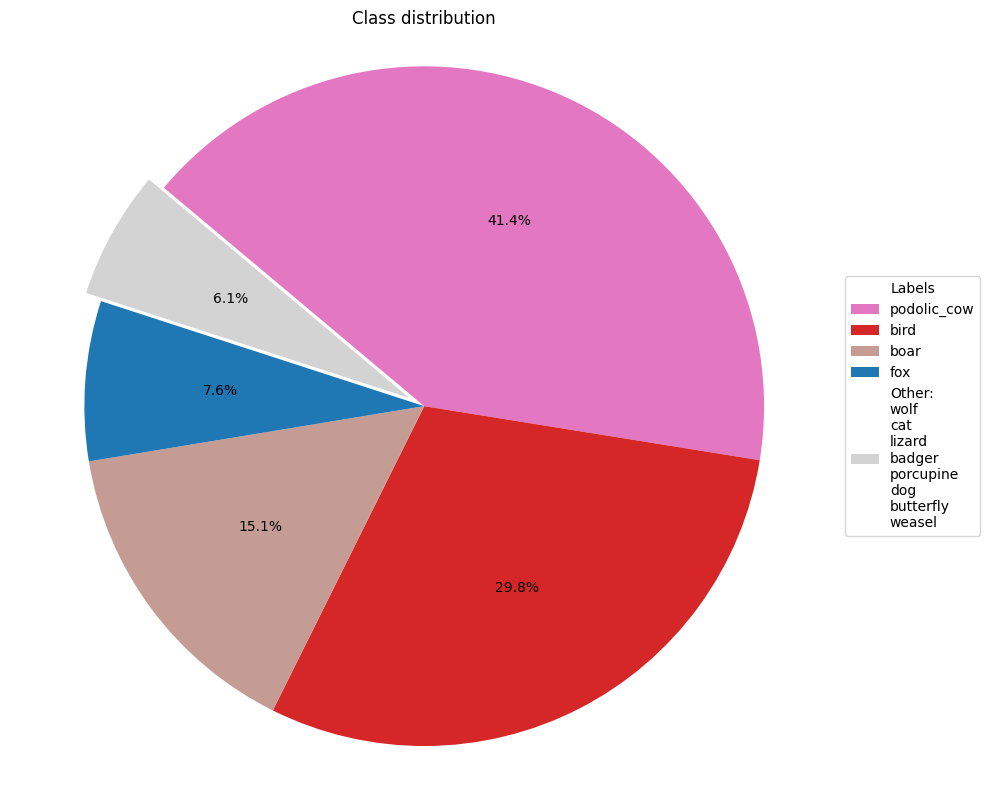

In [4]:
counts = animals_dataset['class'].value_counts()
percent = counts / counts.sum()
threshold = 0.02
main_labels = percent[percent >= threshold]
other_labels = percent[percent < threshold]
combined = main_labels.copy()
if not other_labels.empty:
    combined['Other'] = other_labels.sum()

colors = [color_dict.get(label, "gray") if label != "Other" else "lightgray" for label in combined.index]

combined = main_labels.copy()
if not other_labels.empty:
    combined['Other'] = other_labels.sum()

legend_labels = list(main_labels.index)
if not other_labels.empty:
    other_details = "\n".join(other_labels.index.tolist()) 
    legend_labels.append(f"Other:\n{other_details}")

explode = [0.05 if label == 'Other' else 0 for label in combined.index]

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    combined,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
    explode=explode,
    colors=colors
)

plt.legend(
    wedges,
    legend_labels,
    title="Labels",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Class distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()


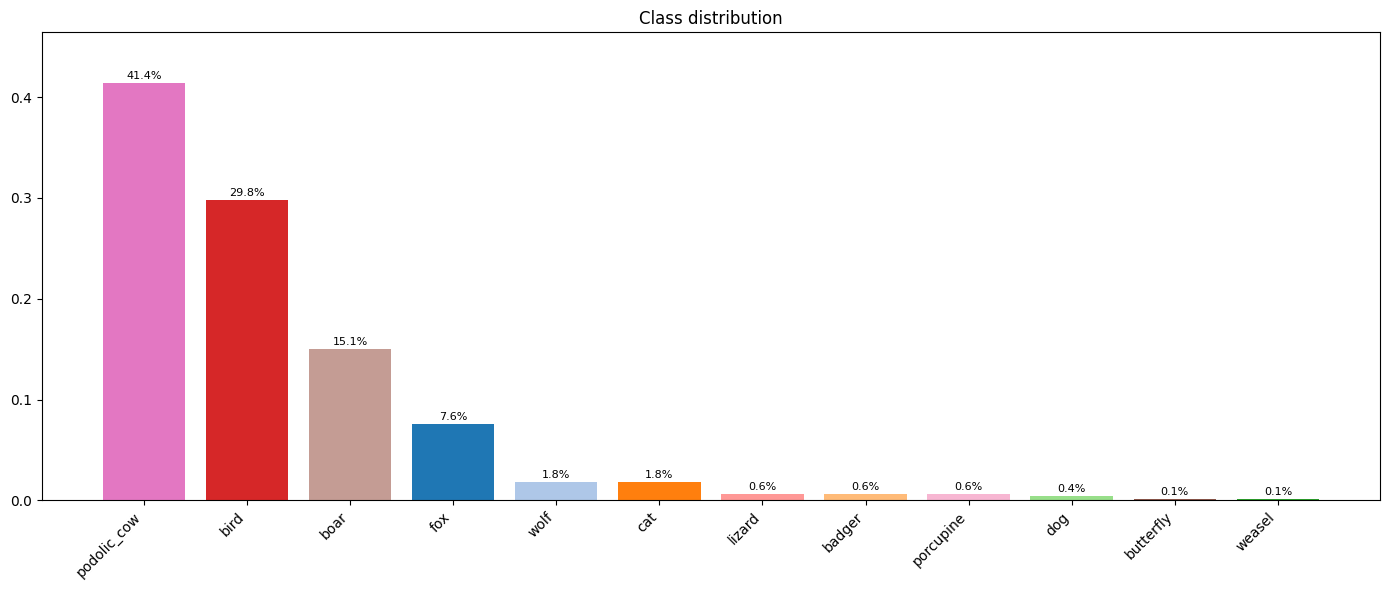

In [5]:
percent = percent.sort_values(ascending=False)

bar_colors = [color_dict.get(cls, "gray") for cls in percent.index]
plt.figure(figsize=(14, 6))
bars = plt.bar(percent.index, percent.values, color=bar_colors)

for bar, value in zip(bars, percent.values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.002, f"{value*100:.1f}%", 
             ha='center', va='bottom', fontsize=8)

plt.title("Class distribution")
plt.ylabel("")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(percent.values) + 0.05) 

plt.tight_layout()
plt.show()

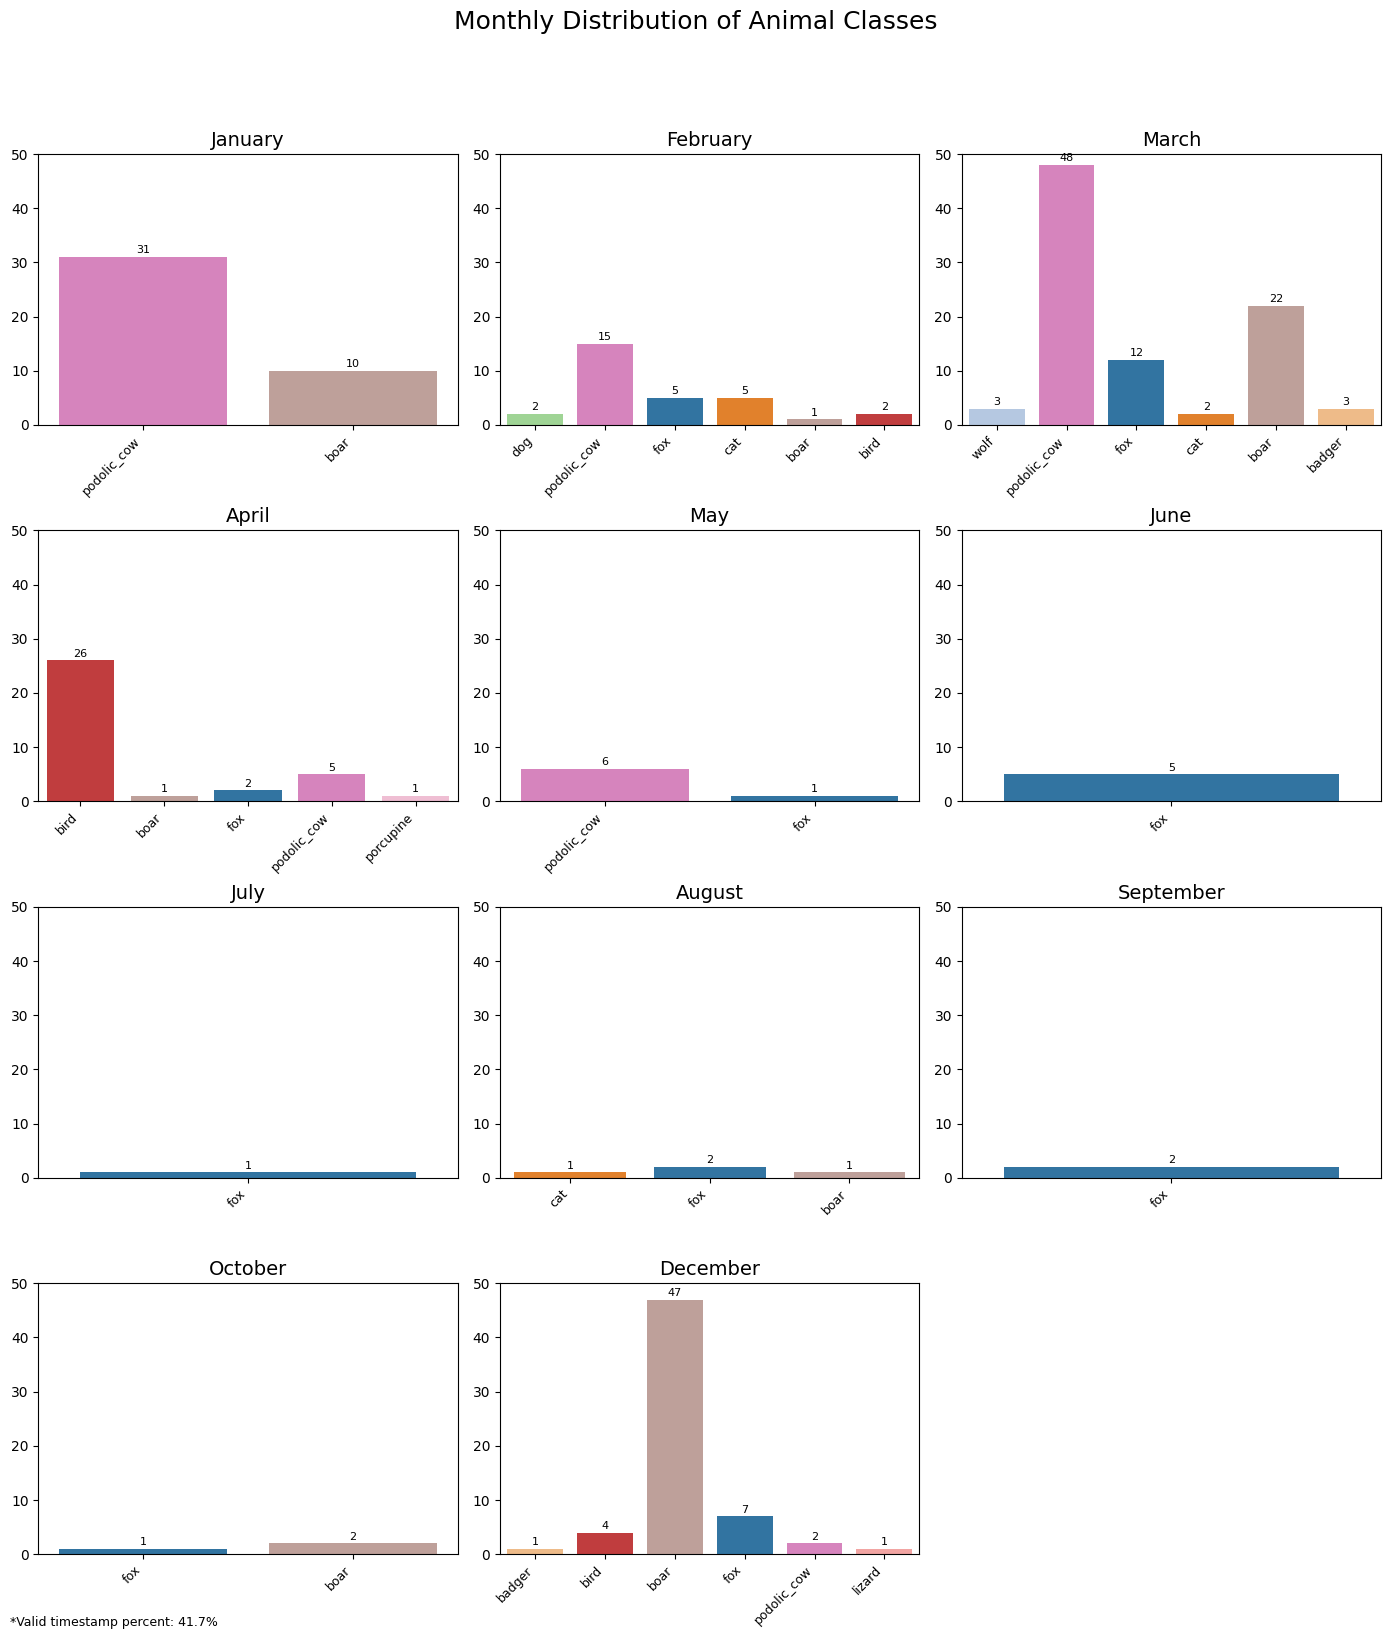

In [ ]:
animal_dataset_timestamp = animals_dataset.copy()
animal_dataset_timestamp["timestamp"] = pd.to_datetime(animal_dataset_timestamp["timestamp"], errors="coerce")
animal_dataset_timestamp = animal_dataset_timestamp.dropna(subset=["timestamp"])

animal_dataset_timestamp["month"] = animal_dataset_timestamp["timestamp"].dt.strftime("%B")

monthly_counts = animal_dataset_timestamp.groupby(["month", "class"]).size().reset_index(name="count")

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
monthly_counts["month"] = pd.Categorical(monthly_counts["month"], categories=month_order, ordered=True)
monthly_counts = monthly_counts.sort_values("month")

monthly_groups = {
    month: monthly_counts[monthly_counts["month"] == month][["class", "count"]]
    for month in monthly_counts["month"].unique()
}

n_months = len(monthly_groups)
ncols = 3
nrows = math.ceil(n_months / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))
axes = axes.flatten()

max_count = monthly_counts["count"].max()
y_limit = max_count + 2

for i, (month, data) in enumerate(monthly_groups.items()):
    ax = axes[i]
    data = data[data["count"] > 0]

    palette_subset = {cls: color_dict[cls] for cls in data["class"]}

    sns.barplot(
        data=data,
        x="class",
        y="count",
        ax=ax,
        palette=palette_subset,
        order=data["class"]
    )

    ax.set_title(month, fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(0, y_limit)
    ax.set_xticklabels(data["class"], rotation=45, ha="right", fontsize=9)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2, height + 0.3, int(height),
                    ha='center', va='bottom', fontsize=8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Monthly Distribution of Animal Classes", fontsize=18, y=1.02)

valid_dates = animals_dataset['timestamp'].notna().sum()
total_entries = len(animals_dataset)
valid_percent = valid_dates / total_entries * 100

plt.figtext(0.01, 0.01, f"*Valid timestamp percent: {valid_percent:.1f}%", 
            ha="left", fontsize=9, color="black")
plt.subplots_adjust(top=0.93)
plt.show()